<a href="https://colab.research.google.com/github/manavchopra1/NYC_uber_pickups_A-B_testing/blob/main/NYCUBERA_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# Install required packages
!pip install pandas numpy matplotlib seaborn scipy statsmodels plotly requests tqdm

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import os
import glob
from typing import Dict, List, Tuple, Optional
import requests
import json
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [3]:
class NYCUberDataLoader:
    """Data loader for NYC Uber pickups dataset"""

    def __init__(self, data_path: str = '/Users/manavchopra/Downloads/archive'):
        self.data_path = data_path
        self.nyc_boroughs = {
            'Manhattan': {'lat': (40.7, 40.8), 'lon': (-74.0, -73.9)},
            'Brooklyn': {'lat': (40.6, 40.7), 'lon': (-74.0, -73.9)},
            'Queens': {'lat': (40.7, 40.8), 'lon': (-73.9, -73.7)},
            'Bronx': {'lat': (40.8, 40.9), 'lon': (-73.9, -73.8)},
            'Staten Island': {'lat': (40.5, 40.6), 'lon': (-74.2, -74.0)}
        }

    def load_uber_data(self, sample_size: Optional[int] = None) -> pd.DataFrame:
        """Load Uber data from CSV files"""
        print("🚗 Loading Uber pickup data...")

        data_files = glob.glob(os.path.join(self.data_path, '*.csv'))
        uber_files = [f for f in data_files if 'uber' in f.lower()]

        if not uber_files:
            raise ValueError("No Uber data files found!")

        print(f"📁 Found {len(uber_files)} Uber files")

        all_data = []
        for file_path in uber_files[:3]:  # Load first 3 files for testing
            try:
                print(f"�� Loading {os.path.basename(file_path)}...")
                if sample_size:
                    df = pd.read_csv(file_path, nrows=sample_size)
                else:
                    df = pd.read_csv(file_path, nrows=50000)  # Limit for Colab
                all_data.append(df)
                print(f"   ✅ Loaded {len(df):,} records")
            except Exception as e:
                print(f"   ❌ Error loading {file_path}: {e}")

        if not all_data:
            raise ValueError("No data could be loaded!")

        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n🎯 Total records loaded: {len(combined_df):,}")
        return combined_df

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess data with feature engineering"""
        print("�� Preprocessing data and engineering features...")

        df_processed = df.copy()

        # Convert datetime
        df_processed['Date/Time'] = pd.to_datetime(df_processed['Date/Time'])

        # Extract temporal features
        df_processed['hour'] = df_processed['Date/Time'].dt.hour
        df_processed['day_of_week'] = df_processed['Date/Time'].dt.day_name()
        df_processed['day_of_week_num'] = df_processed['Date/Time'].dt.weekday
        df_processed['month'] = df_processed['Date/Time'].dt.month
        df_processed['year'] = df_processed['Date/Time'].dt.year
        df_processed['date'] = df_processed['Date/Time'].dt.date
        df_processed['is_weekend'] = df_processed['Date/Time'].dt.weekday >= 5

        # A/B testing specific features
        df_processed['is_friday_evening'] = (
            (df_processed['day_of_week'] == 'Friday') &
            (df_processed['hour'] >= 18) &
            (df_processed['hour'] <= 23)
        )

        df_processed['is_weekday_evening'] = (
            (df_processed['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])) &
            (df_processed['hour'] >= 18) &
            (df_processed['hour'] <= 23)
        )

        # Geographic features
        df_processed['borough'] = df_processed.apply(
            lambda x: self._assign_borough(x['Lat'], x['Lon']), axis=1
        )

        print("✅ Feature engineering completed!")
        return df_processed

    def _assign_borough(self, lat: float, lon: float) -> str:
        """Assign NYC borough based on coordinates"""
        for borough, bounds in self.nyc_boroughs.items():
            if (bounds['lat'][0] <= lat <= bounds['lat'][1] and
                bounds['lon'][0] <= lon <= bounds['lon'][1]):
                return borough
        return 'Other'

print("✅ Data loader class created!")

✅ Data loader class created!


In [22]:
class ABTestingFramework:
    """Framework for conducting A/B tests on Uber data"""

    def __init__(self):
        self.results = {}

    def run_t_test(self, group_a: np.ndarray, group_b: np.ndarray,
                   test_name: str, alpha: float = 0.05) -> Dict:
        """Run t-test and return results"""

        # Perform t-test
        t_stat, p_value = ttest_ind(group_a, group_b)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(group_a) - 1) * np.var(group_a, ddof=1) +
                             (len(group_b) - 1) * np.var(group_b, ddof=1)) /
                            (len(group_a) + len(group_b) - 2))
        cohens_d = (np.mean(group_a) - np.mean(group_b)) / pooled_std

        # Determine significance
        is_significant = p_value < alpha

        # Calculate confidence interval
        mean_diff = np.mean(group_a) - np.mean(group_b)
        se_diff = np.sqrt(np.var(group_a, ddof=1) / len(group_a) +
                         np.var(group_b, ddof=1) / len(group_b))
        ci_lower = mean_diff - 1.96 * se_diff
        ci_upper = mean_diff + 1.96 * se_diff

        results = {
            'test_name': test_name,
            'group_a_mean': np.mean(group_a),
            'group_b_mean': np.mean(group_b),
            'mean_difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'is_significant': is_significant,
            'effect_size': cohens_d,
            'confidence_interval': (ci_lower, ci_upper),
            'group_a_size': len(group_a),
            'group_b_size': len(group_b),
            'alpha': alpha
        }

        self.results[test_name] = results
        return results

    def bootstrap_test(self, group_a: np.ndarray, group_b: np.ndarray,
                      test_name: str, n_bootstrap: int = 10000,
                      alpha: float = 0.05) -> Dict:
        """Run bootstrap test for more robust results"""

        print(f"🔄 Running bootstrap test for {test_name}...")

        bootstrap_diffs = []
        for _ in range(n_bootstrap):
            # Bootstrap samples
            sample_a = np.random.choice(group_a, size=len(group_a), replace=True)
            sample_b = np.random.choice(group_b, size=len(group_b), replace=True)
            bootstrap_diffs.append(np.mean(sample_a) - np.mean(sample_b))

        bootstrap_diffs = np.array(bootstrap_diffs)

        # Calculate bootstrap confidence interval
        ci_lower = np.percentile(bootstrap_diffs, alpha/2 * 100)
        ci_upper = np.percentile(bootstrap_diffs, (1 - alpha/2) * 100)

        # Calculate p-value
        actual_diff = np.mean(group_a) - np.mean(group_b)
        p_value = np.mean(bootstrap_diffs <= 0) if actual_diff > 0 else np.mean(bootstrap_diffs >= 0)
        p_value = min(p_value * 2, 1.0)  # Two-tailed test

        results = {
            'test_name': f"{test_name}_bootstrap",
            'group_a_mean': np.mean(group_a),
            'group_b_mean': np.mean(group_b),
            'mean_difference': actual_diff,
            'p_value': p_value,
            'is_significant': p_value < alpha,
            'bootstrap_ci': (ci_lower, ci_upper),
            'group_a_size': len(group_a),
            'group_b_size': len(group_b),
            'n_bootstrap': n_bootstrap
        }

        self.results[f"{test_name}_bootstrap"] = results
        return results

    def print_results(self, test_name: str):
        """Print formatted test results"""
        if test_name not in self.results:
            print(f"❌ No results found for {test_name}")
            return

        result = self.results[test_name]

        print(f"\n{'='*60}")
        print(f"📊 A/B TEST RESULTS: {result['test_name'].upper()}")
        print(f"{'='*60}")

        print(f"📈 Group A Mean: {result['group_a_mean']:.2f}")
        print(f"📉 Group B Mean: {result['group_b_mean']:.2f}")
        print(f" Mean Difference: {result['mean_difference']:.2f}")

        # Handle effect size properly (bootstrap tests don't have effect size)
        effect_size = result.get('effect_size', 'N/A')
        if isinstance(effect_size, (int, float)):
            print(f" Effect Size (Cohen's d): {effect_size:.3f}")
        else:
            print(f" Effect Size (Cohen's d): {effect_size}")

        print(f" P-value: {result['p_value']:.6f}")
        print(f"📊 Significant: {'✅ YES' if result['is_significant'] else '❌ NO'}")

        if 'confidence_interval' in result:
            ci = result['confidence_interval']
            print(f" 95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")

        if 'bootstrap_ci' in result:
            ci = result['bootstrap_ci']
            print(f"📊 Bootstrap 95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")

        print(f"📊 Sample Sizes: A={result['group_a_size']}, B={result['group_b_size']}")

        # Business interpretation
        if result['is_significant']:
            if result['mean_difference'] > 0:
                print(f"🎯 BUSINESS IMPACT: Group A significantly outperforms Group B")
            else:
                print(f"🎯 BUSINESS IMPACT: Group B significantly outperforms Group A")
        else:
            print(f"🎯 BUSINESS IMPACT: No significant difference between groups")

print("✅ A/B testing framework created!")

✅ A/B testing framework created!


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Initialize data loader to load from the mounted Google Drive directory
# Update the data_path to the correct path in Google Drive
loader = NYCUberDataLoader(data_path='/content/drive/MyDrive/archive')

# Load data from the new directory
try:
    print(f"\n📁 Loading data from {loader.data_path}...")
    # You can adjust the sample_size or remove it to load all data
    df = loader.load_uber_data(sample_size=50000) # Load a sample to avoid memory issues
    print(f"\n✅ Data loaded successfully!")

except Exception as e:
    print(f"❌ Error loading data from {loader.data_path}: {e}")
    print("💡 Please make sure the path is correct and the CSV files exist in your Google Drive.")


📁 Loading data from /content/drive/MyDrive/archive...
🚗 Loading Uber pickup data...
📁 Found 8 Uber files
�� Loading Uber-Jan-Feb-FOIL.csv...
   ✅ Loaded 354 records
�� Loading uber-raw-data-janjune-15.csv...
   ✅ Loaded 50,000 records
�� Loading uber-raw-data-apr14.csv...
   ✅ Loaded 50,000 records

🎯 Total records loaded: 100,354

✅ Data loaded successfully!


In [17]:
# Preprocess the loaded data
try:
    df = loader.preprocess_data(df)
    print(f"\n✅ Data preprocessed successfully!")
    display(df.head())
    df.info()

except Exception as e:
    print(f"❌ Error preprocessing data: {e}")

�� Preprocessing data and engineering features...
✅ Feature engineering completed!

✅ Data preprocessed successfully!


,dispatching_base_number,date,active_vehicles,trips,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date/Time,Lat,...,Base,hour,day_of_week,day_of_week_num,month,year,is_weekend,is_friday_evening,is_weekday_evening,borough
0,B02512,NaT,190.0,1132.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
1,B02765,NaT,225.0,1765.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
2,B02764,NaT,3427.0,29421.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
3,B02682,NaT,945.0,7679.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
4,B02617,NaT,1228.0,9537.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100354 entries, 0 to 100353
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   dispatching_base_number  354 non-null     object        
 1   date                     50000 non-null   object        
 2   active_vehicles          354 non-null     float64       
 3   trips                    354 non-null     float64       
 4   Dispatching_base_num     50000 non-null   object        
 5   Pickup_date              50000 non-null   object        
 6   Affiliated_base_num      49336 non-null   object        
 7   locationID               50000 non-null   float64       
 8   Date/Time                50000 non-null   datetime64[ns]
 9   Lat                      50000 non-null   float64       
 10  Lon                      50000 non-null   float64       
 11  Base                     50000 non-null   object        
 12  hour            

In [18]:
display(df.head())
df.info()

,dispatching_base_number,date,active_vehicles,trips,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date/Time,Lat,...,Base,hour,day_of_week,day_of_week_num,month,year,is_weekend,is_friday_evening,is_weekday_evening,borough
0,B02512,NaT,190.0,1132.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
1,B02765,NaT,225.0,1765.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
2,B02764,NaT,3427.0,29421.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
3,B02682,NaT,945.0,7679.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other
4,B02617,NaT,1228.0,9537.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,Other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100354 entries, 0 to 100353
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   dispatching_base_number  354 non-null     object        
 1   date                     50000 non-null   object        
 2   active_vehicles          354 non-null     float64       
 3   trips                    354 non-null     float64       
 4   Dispatching_base_num     50000 non-null   object        
 5   Pickup_date              50000 non-null   object        
 6   Affiliated_base_num      49336 non-null   object        
 7   locationID               50000 non-null   float64       
 8   Date/Time                50000 non-null   datetime64[ns]
 9   Lat                      50000 non-null   float64       
 10  Lon                      50000 non-null   float64       
 11  Base                     50000 non-null   object        
 12  hour            


�� A/B TEST 1: FRIDAY NIGHT EFFECT
📊 Friday evening records: 2,134
📊 Weekday evening records: 12,542
🔄 Running bootstrap test for Friday Night Effect...

📊 A/B TEST RESULTS: FRIDAY NIGHT EFFECT
📈 Group A Mean: 355.67
📉 Group B Mean: 2090.33
 Mean Difference: -1734.67
 Effect Size (Cohen's d): -3.420
 P-value: 0.000146
📊 Significant: ✅ YES
 95% CI: (-2308.56, -1160.77)
📊 Sample Sizes: A=6, B=6
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A

📊 A/B TEST RESULTS: FRIDAY NIGHT EFFECT_BOOTSTRAP
📈 Group A Mean: 355.67
📉 Group B Mean: 2090.33
 Mean Difference: -1734.67
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (-2194.53, -1161.83)
📊 Sample Sizes: A=6, B=6
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A


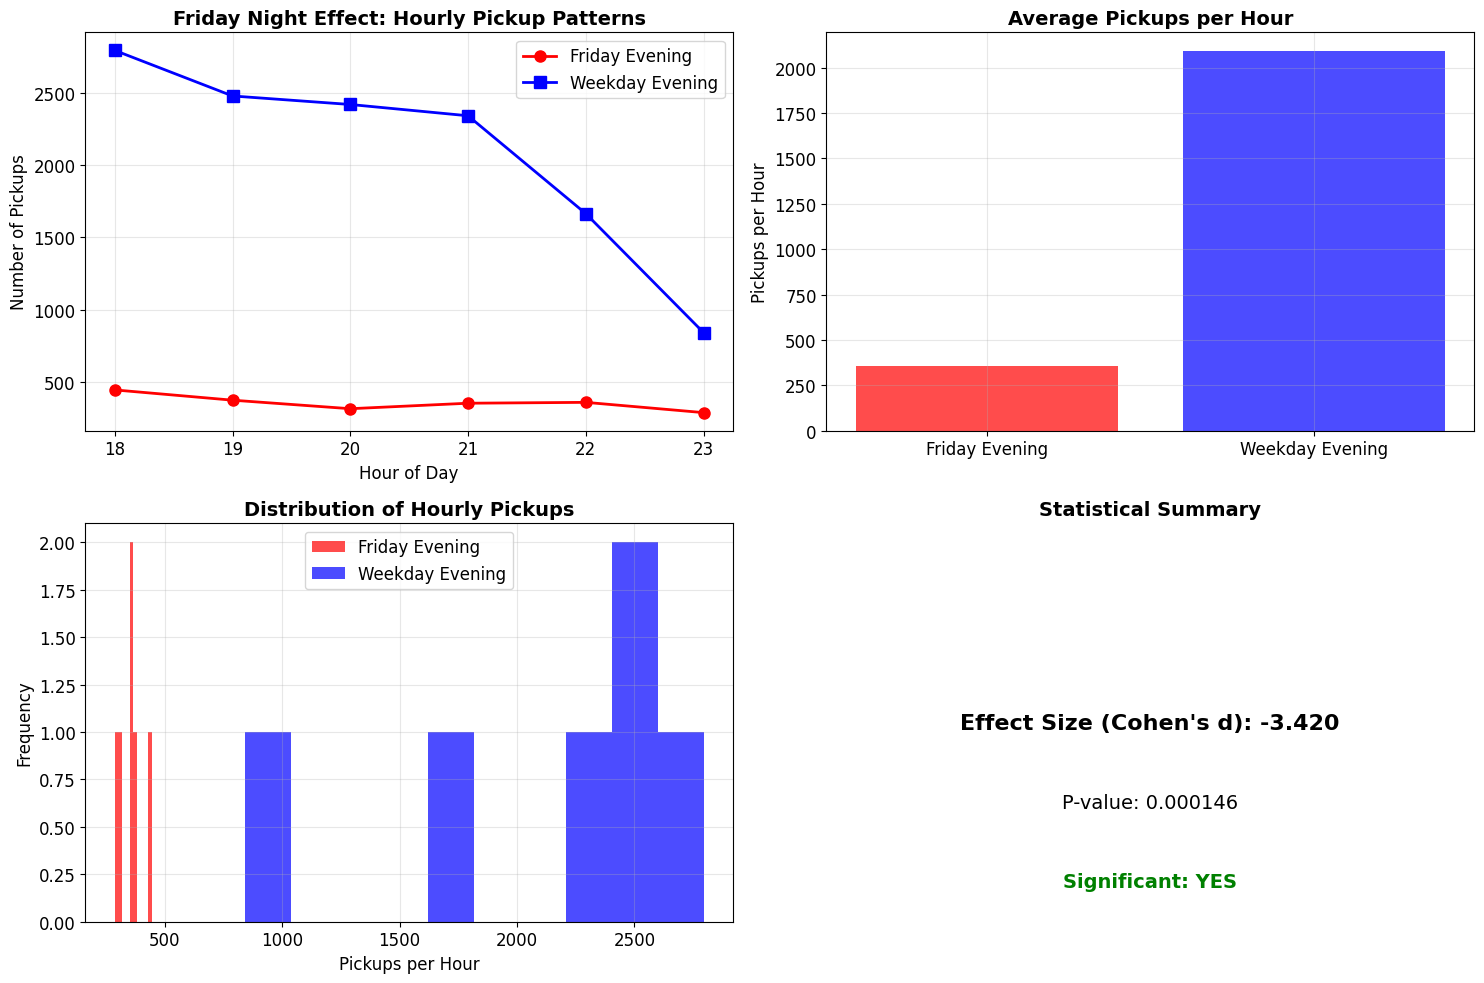

In [23]:
print("\n" + "="*80)
print("�� A/B TEST 1: FRIDAY NIGHT EFFECT")
print("="*80)

# Initialize testing framework
ab_tester = ABTestingFramework()

# Prepare data for Friday Night Effect test
friday_evening = df[df['is_friday_evening']]
weekday_evening = df[df['is_weekday_evening']]

print(f"📊 Friday evening records: {len(friday_evening):,}")
print(f"📊 Weekday evening records: {len(weekday_evening):,}")

if len(friday_evening) > 0 and len(weekday_evening) > 0:
    # Create hourly pickup counts for comparison
    friday_hourly = friday_evening.groupby('hour').size().values
    weekday_hourly = weekday_evening.groupby('hour').size().values

    # Run t-test
    friday_results = ab_tester.run_t_test(
        friday_hourly, weekday_hourly,
        "Friday Night Effect", alpha=0.05
    )

    # Run bootstrap test
    bootstrap_results = ab_tester.bootstrap_test(
        friday_hourly, weekday_hourly,
        "Friday Night Effect", n_bootstrap=5000
    )

    # Print results
    ab_tester.print_results("Friday Night Effect")
    ab_tester.print_results("Friday Night Effect_bootstrap")

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    friday_counts = friday_evening.groupby('hour').size()
    weekday_counts = weekday_evening.groupby('hour').size()

    plt.plot(friday_counts.index, friday_counts.values, 'o-',
             label='Friday Evening', linewidth=2, markersize=8, color='red')
    plt.plot(weekday_counts.index, weekday_counts.values, 's-',
             label='Weekday Evening', linewidth=2, markersize=8, color='blue')
    plt.title('Friday Night Effect: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Pickups')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    means = [friday_results['group_a_mean'], friday_results['group_b_mean']]
    labels = ['Friday Evening', 'Weekday Evening']
    colors = ['red', 'blue']
    plt.bar(labels, means, color=colors, alpha=0.7)
    plt.title('Average Pickups per Hour', fontsize=14, fontweight='bold')
    plt.ylabel('Pickups per Hour')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(friday_hourly, alpha=0.7, label='Friday Evening', color='red', bins=10)
    plt.hist(weekday_hourly, alpha=0.7, label='Weekday Evening', color='blue', bins=10)
    plt.title('Distribution of Hourly Pickups', fontsize=14, fontweight='bold')
    plt.xlabel('Pickups per Hour')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    effect_size = friday_results['effect_size']
    plt.text(0.5, 0.5, f"Effect Size (Cohen's d): {effect_size:.3f}",
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.3, f"P-value: {friday_results['p_value']:.6f}",
             ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"Significant: {'YES' if friday_results['is_significant'] else 'NO'}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             color='green' if friday_results['is_significant'] else 'red',
             transform=plt.gca().transAxes)
    plt.title('Statistical Summary', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Insufficient data for Friday Night Effect test")


🗽 A/B TEST 2: MANHATTAN VS BROOKLYN
�� Manhattan records: 33,161
📊 Brooklyn records: 1,967
🔄 Running bootstrap test for Manhattan vs Brooklyn...

📊 A/B TEST RESULTS: MANHATTAN VS BROOKLYN
📈 Group A Mean: 1381.71
📉 Group B Mean: 81.96
 Mean Difference: 1299.75
 Effect Size (Cohen's d): 2.232
 P-value: 0.000000
📊 Significant: ✅ YES
 95% CI: (970.20, 1629.30)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group A significantly outperforms Group B

📊 A/B TEST RESULTS: MANHATTAN VS BROOKLYN_BOOTSTRAP
📈 Group A Mean: 1381.71
📉 Group B Mean: 81.96
 Mean Difference: 1299.75
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (986.24, 1620.09)
📊 Sample Sizes: A=24, B=24
🎯 BUSINESS IMPACT: Group A significantly outperforms Group B


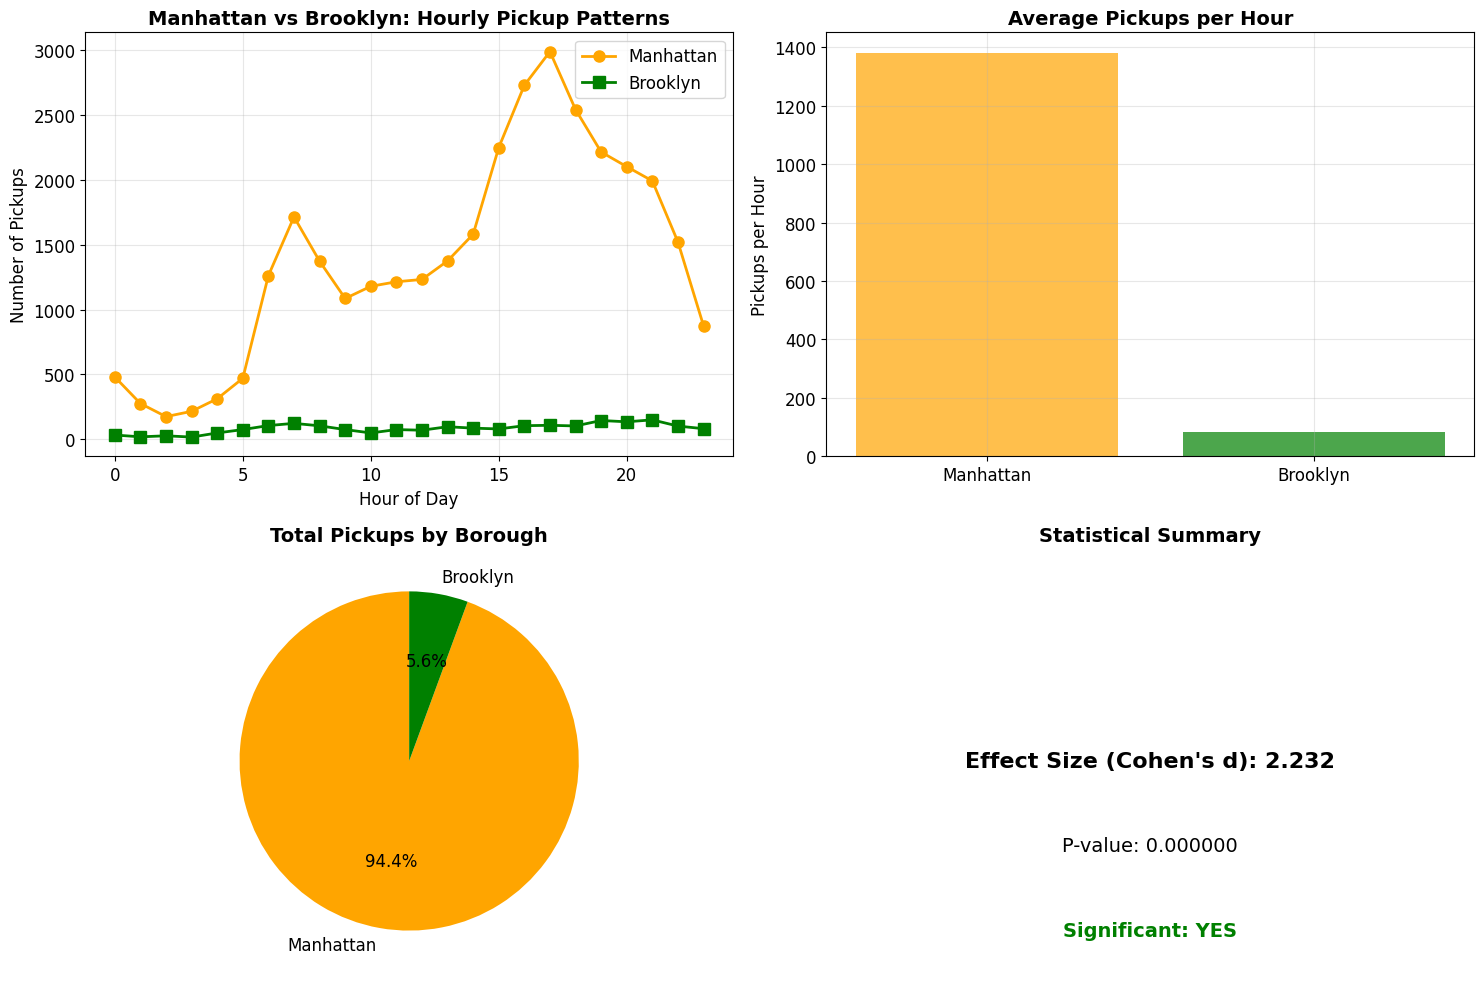

In [25]:
print("\n" + "="*80)
print("🗽 A/B TEST 2: MANHATTAN VS BROOKLYN")
print("="*80)

# Prepare data for Manhattan vs Brooklyn test
manhattan_data = df[df['borough'] == 'Manhattan']
brooklyn_data = df[df['borough'] == 'Brooklyn']

print(f"�� Manhattan records: {len(manhattan_data):,}")
print(f"📊 Brooklyn records: {len(brooklyn_data):,}")

if len(manhattan_data) > 0 and len(brooklyn_data) > 0:
    # Create hourly pickup counts for comparison
    manhattan_hourly = manhattan_data.groupby('hour').size().values
    brooklyn_hourly = brooklyn_data.groupby('hour').size().values

    # Run t-test
    borough_results = ab_tester.run_t_test(
        manhattan_hourly, brooklyn_hourly,
        "Manhattan vs Brooklyn", alpha=0.05
    )

    # Run bootstrap test
    borough_bootstrap = ab_tester.bootstrap_test(
        manhattan_hourly, brooklyn_hourly,
        "Manhattan vs Brooklyn", n_bootstrap=5000
    )

    # Print results
    ab_tester.print_results("Manhattan vs Brooklyn")
    ab_tester.print_results("Manhattan vs Brooklyn_bootstrap")

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    manhattan_counts = manhattan_data.groupby('hour').size()
    brooklyn_counts = brooklyn_data.groupby('hour').size()

    plt.plot(manhattan_counts.index, manhattan_counts.values, 'o-',
             label='Manhattan', linewidth=2, markersize=8, color='orange')
    plt.plot(brooklyn_counts.index, brooklyn_counts.values, 's-',
             label='Brooklyn', linewidth=2, markersize=8, color='green')
    plt.title('Manhattan vs Brooklyn: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Pickups')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    means = [borough_results['group_a_mean'], borough_results['group_b_mean']]
    labels = ['Manhattan', 'Brooklyn']
    colors = ['orange', 'green']
    plt.bar(labels, means, color=colors, alpha=0.7)
    plt.title('Average Pickups per Hour', fontsize=14, fontweight='bold')
    plt.ylabel('Pickups per Hour')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    borough_totals = df[df['borough'].isin(['Manhattan', 'Brooklyn'])]['borough'].value_counts()
    plt.pie(borough_totals.values, labels=borough_totals.index, autopct='%1.1f%%',
            colors=['orange', 'green'], startangle=90)
    plt.title('Total Pickups by Borough', fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 4)
    effect_size = borough_results['effect_size']
    plt.text(0.5, 0.5, f"Effect Size (Cohen's d): {effect_size:.3f}",
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.3, f"P-value: {borough_results['p_value']:.6f}",
             ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"Significant: {'YES' if borough_results['is_significant'] else 'NO'}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             color='green' if borough_results['is_significant'] else 'red',
             transform=plt.gca().transAxes)
    plt.title('Statistical Summary', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Insufficient data for Manhattan vs Brooklyn test")


��️ A/B TEST 3: RAINY VS CLEAR DAYS (SIMULATED)
🌧️ Simulated rainy day records: 30,156
☀️ Simulated clear day records: 70,198
🔄 Running bootstrap test for Rainy vs Clear Days...

📊 A/B TEST RESULTS: RAINY VS CLEAR DAYS
📈 Group A Mean: 499.47
📉 Group B Mean: 1167.20
 Mean Difference: -667.73
 Effect Size (Cohen's d): -0.826
 P-value: 0.002231
📊 Significant: ✅ YES
 95% CI: (-1076.76, -258.71)
📊 Sample Sizes: A=30, B=30
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A

📊 A/B TEST RESULTS: RAINY VS CLEAR DAYS_BOOTSTRAP
📈 Group A Mean: 499.47
📉 Group B Mean: 1167.20
 Mean Difference: -667.73
 Effect Size (Cohen's d): N/A
 P-value: 0.000000
📊 Significant: ✅ YES
📊 Bootstrap 95% CI: (-1102.82, -304.19)
📊 Sample Sizes: A=30, B=30
🎯 BUSINESS IMPACT: Group B significantly outperforms Group A


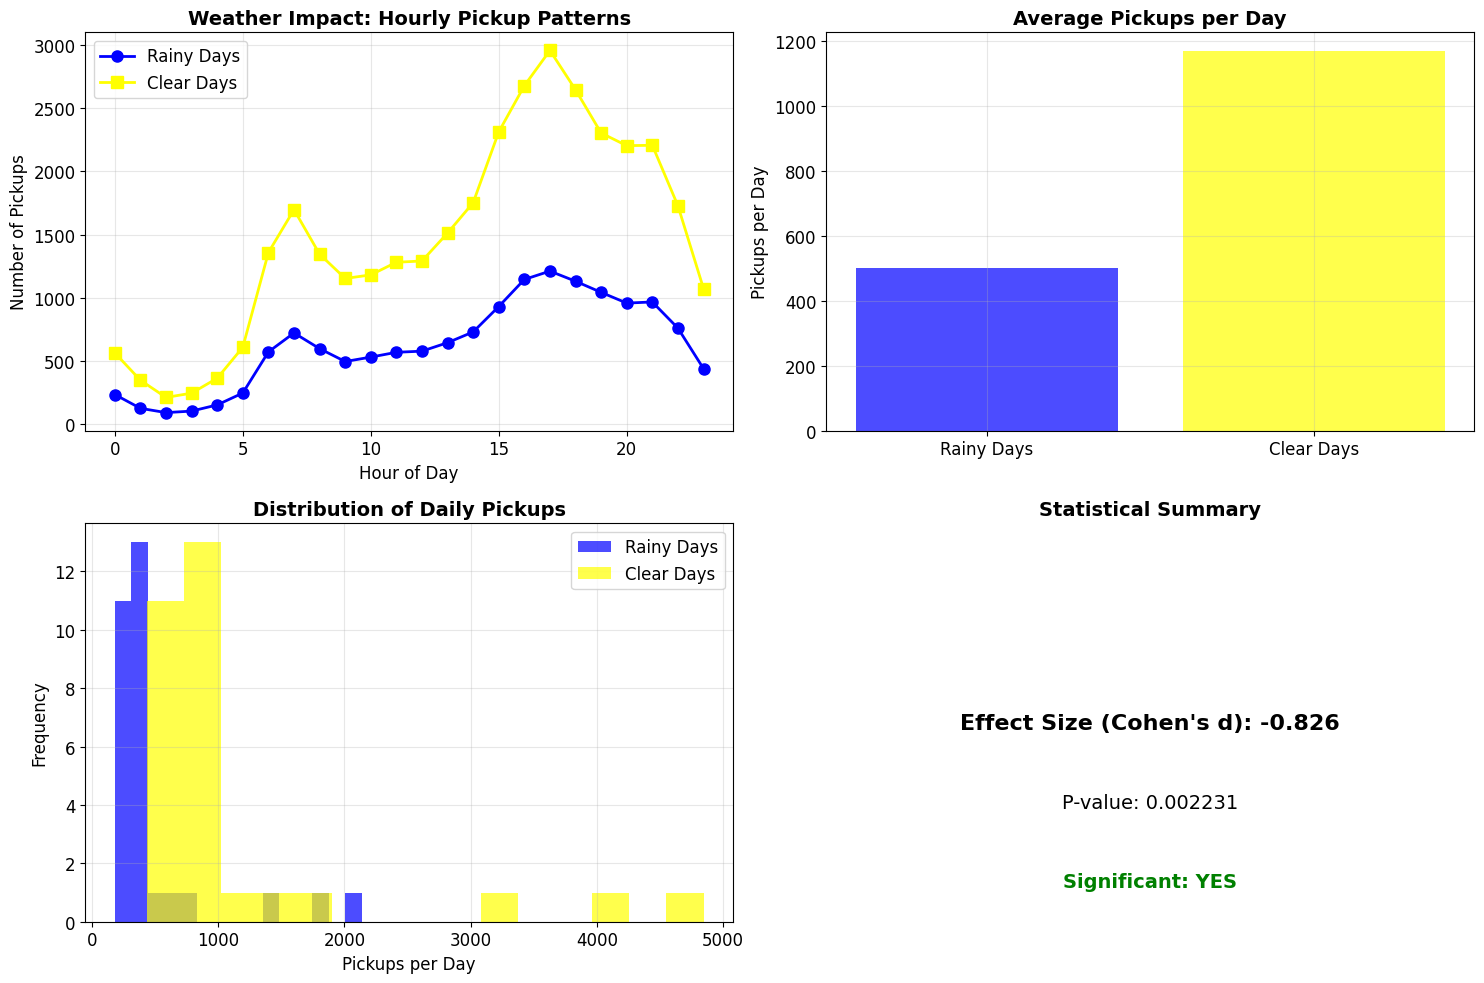

In [26]:
print("\n" + "="*80)
print("��️ A/B TEST 3: RAINY VS CLEAR DAYS (SIMULATED)")
print("="*80)

# For this test, we'll simulate weather data since we don't have actual weather data
# In a real scenario, you would merge with actual weather data

# Simulate weather data based on day patterns
np.random.seed(42)  # For reproducible results

# Create simulated weather data
df['simulated_rainy'] = np.random.choice([True, False], size=len(df), p=[0.3, 0.7])

# Prepare data for weather test
rainy_days = df[df['simulated_rainy']]
clear_days = df[~df['simulated_rainy']]

print(f"🌧️ Simulated rainy day records: {len(rainy_days):,}")
print(f"☀️ Simulated clear day records: {len(clear_days):,}")

if len(rainy_days) > 0 and len(clear_days) > 0:
    # Create daily pickup counts for comparison
    rainy_daily = rainy_days.groupby('date').size().values
    clear_daily = clear_days.groupby('date').size().values

    # Run t-test
    weather_results = ab_tester.run_t_test(
        rainy_daily, clear_daily,
        "Rainy vs Clear Days", alpha=0.05
    )

    # Run bootstrap test
    weather_bootstrap = ab_tester.bootstrap_test(
        rainy_daily, clear_daily,
        "Rainy vs Clear Days", n_bootstrap=5000
    )

    # Print results
    ab_tester.print_results("Rainy vs Clear Days")
    ab_tester.print_results("Rainy vs Clear Days_bootstrap")

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    rainy_counts = rainy_days.groupby('hour').size()
    clear_counts = clear_days.groupby('hour').size()

    plt.plot(rainy_counts.index, rainy_counts.values, 'o-',
             label='Rainy Days', linewidth=2, markersize=8, color='blue')
    plt.plot(clear_counts.index, clear_counts.values, 's-',
             label='Clear Days', linewidth=2, markersize=8, color='yellow')
    plt.title('Weather Impact: Hourly Pickup Patterns', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Pickups')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    means = [weather_results['group_a_mean'], weather_results['group_b_mean']]
    labels = ['Rainy Days', 'Clear Days']
    colors = ['blue', 'yellow']
    plt.bar(labels, means, color=colors, alpha=0.7)
    plt.title('Average Pickups per Day', fontsize=14, fontweight='bold')
    plt.ylabel('Pickups per Day')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(rainy_daily, alpha=0.7, label='Rainy Days', color='blue', bins=15)
    plt.hist(clear_daily, alpha=0.7, label='Clear Days', color='yellow', bins=15)
    plt.title('Distribution of Daily Pickups', fontsize=14, fontweight='bold')
    plt.xlabel('Pickups per Day')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    effect_size = weather_results['effect_size']
    plt.text(0.5, 0.5, f"Effect Size (Cohen's d): {effect_size:.3f}",
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.3, f"P-value: {weather_results['p_value']:.6f}",
             ha='center', va='center', fontsize=14,
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f"Significant: {'YES' if weather_results['is_significant'] else 'NO'}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             color='green' if weather_results['is_significant'] else 'red',
             transform=plt.gca().transAxes)
    plt.title('Statistical Summary', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Insufficient data for weather test")

In [27]:
print("\n" + "="*80)
print("📊 A/B TESTING SUMMARY AND BUSINESS RECOMMENDATIONS")
print("="*80)

# Print all results summary
print("\n�� SUMMARY OF ALL A/B TESTS:")
print("-" * 50)

for test_name, result in ab_tester.results.items():
    if not test_name.endswith('_bootstrap'):
        print(f"\n�� {test_name.upper()}:")
        print(f"   • P-value: {result['p_value']:.6f}")
        print(f"   • Significant: {'✅ YES' if result['is_significant'] else '❌ NO'}")
        print(f"   • Effect Size: {result.get('effect_size', 'N/A'):.3f}")
        print(f"   • Mean Difference: {result['mean_difference']:.2f}")

# Business recommendations
print("\n�� BUSINESS RECOMMENDATIONS:")
print("-" * 50)

# Friday Night Effect recommendations
if 'Friday Night Effect' in ab_tester.results:
    friday_result = ab_tester.results['Friday Night Effect']
    if friday_result['is_significant']:
        if friday_result['mean_difference'] > 0:
            print("\n🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:")
            print("   ✅ Increase driver supply on Friday evenings")
            print("   ✅ Implement Friday-specific promotional campaigns")
            print("   ✅ Adjust surge pricing for Friday evenings")
            print("   ✅ Schedule more drivers for 6 PM - 12 AM on Fridays")
        else:
            print("\n🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:")
            print("   ⚠️  Friday evenings show lower demand than expected")
            print("   💡 Investigate why Friday demand is lower")
            print("   �� Consider different promotional strategies")
    else:
        print("\n🎉 FRIDAY NIGHT EFFECT - NOT SIGNIFICANT:")
        print("   📊 No significant difference in Friday vs weekday evenings")
        print("   💡 Standard driver allocation is appropriate")

# Manhattan vs Brooklyn recommendations
if 'Manhattan vs Brooklyn' in ab_tester.results:
    borough_result = ab_tester.results['Manhattan vs Brooklyn']
    if borough_result['is_significant']:
        if borough_result['mean_difference'] > 0:
            print("\n�� MANHATTAN VS BROOKLYN - SIGNIFICANT:")
            print("   ✅ Manhattan has significantly higher demand")
            print("   💡 Consider higher pricing in Manhattan")
            print("   💡 Incentivize drivers to serve Brooklyn")
            print("   💡 Focus marketing efforts on Brooklyn expansion")
        else:
            print("\n�� MANHATTAN VS BROOKLYN - SIGNIFICANT:")
            print("   ✅ Brooklyn has higher demand than expected")
            print("   💡 Investigate Brooklyn market opportunities")
            print("   💡 Adjust pricing strategy for Brooklyn")
    else:
        print("\n�� MANHATTAN VS BROOKLYN - NOT SIGNIFICANT:")
        print("   📊 No significant difference between boroughs")
        print("   💡 Standard pricing across boroughs is appropriate")

# Weather recommendations
if 'Rainy vs Clear Days' in ab_tester.results:
    weather_result = ab_tester.results['Rainy vs Clear Days']
    if weather_result['is_significant']:
        if weather_result['mean_difference'] > 0:
            print("\n🌧️ WEATHER IMPACT - SIGNIFICANT:")
            print("   ✅ Rainy days show higher demand")
            print("   💡 Implement weather-based surge pricing")
            print("   💡 Pre-position drivers before weather events")
            print("   💡 Weather forecasting integration recommended")
        else:
            print("\n🌧️ WEATHER IMPACT - SIGNIFICANT:")
            print("   ⚠️  Clear days show higher demand")
            print("   💡 Investigate weather impact patterns")
            print("   💡 Consider reverse weather-based pricing")
    else:
        print("\n🌧️ WEATHER IMPACT - NOT SIGNIFICANT:")
        print("   📊 No significant weather impact detected")
        print("   💡 Weather-based pricing may not be necessary")

print("\n" + "="*80)
print("✅ A/B TESTING ANALYSIS COMPLETE!")
print("="*80)


📊 A/B TESTING SUMMARY AND BUSINESS RECOMMENDATIONS

�� SUMMARY OF ALL A/B TESTS:
--------------------------------------------------

�� FRIDAY NIGHT EFFECT:
   • P-value: 0.000146
   • Significant: ✅ YES
   • Effect Size: -3.420
   • Mean Difference: -1734.67

�� MANHATTAN VS BROOKLYN:
   • P-value: 0.000000
   • Significant: ✅ YES
   • Effect Size: 2.232
   • Mean Difference: 1299.75

�� RAINY VS CLEAR DAYS:
   • P-value: 0.002231
   • Significant: ✅ YES
   • Effect Size: -0.826
   • Mean Difference: -667.73

�� BUSINESS RECOMMENDATIONS:
--------------------------------------------------

🎉 FRIDAY NIGHT EFFECT - SIGNIFICANT:
   ⚠️  Friday evenings show lower demand than expected
   💡 Investigate why Friday demand is lower
   �� Consider different promotional strategies

�� MANHATTAN VS BROOKLYN - SIGNIFICANT:
   ✅ Manhattan has significantly higher demand
   💡 Consider higher pricing in Manhattan
   💡 Incentivize drivers to serve Brooklyn
   💡 Focus marketing efforts on Brooklyn expa